BASED ON https://github.com/bnsreenu/python_for_microscopists/blob/master/216_mito_unet__xferlearn_12_training_images.py

In [864]:
import tensorflow as tf

In [865]:
import keras 
keras.__version__

'2.13.1'

In [866]:
import numpy as np
from matplotlib import pyplot as plt 
from patchify import patchify
import tifffile as tiff
import cv2 as cv
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

In [867]:
# Reads tiff image stack files
# Replace with appropriate image path
cell_body_image_stack = tiff.imread('/Users/group_user/Downloads/image_stack_for_cell_body_final.tif')
cell_body_mask_stack = tiff.imread('/Users/group_user/Downloads/label_stack_for_cell_body_final.tif')

In [868]:
# Check the shape of the stack (make sure that it is the same size as your stack)
print(cell_body_image_stack.shape)
print(cell_body_mask_stack.shape)

(44, 2560, 2160)
(44, 2560, 2160)


In [869]:
# Need to resize each image to be square for the model to process the image
# Pick square dimension closest to the actual dimension of the image that is a multiple of 12
size = (2048, 2048)

# Here will patchify the images
# Choose an appropriate patchify size (smaller for more detailed segmentations)
# If the patchify is too small, the model will struggle to produce accurate predictions


all_img_patches = []
# iterates over all images in the image stack
for img in range(cell_body_image_stack.shape[0]):
    large_image = cell_body_image_stack[img]
    # Resize each image
    large_image = cv.resize(large_image, size)
    # Patchify each image, to change patchify size modify (512, 512) to be something else
    # Step should be the same size as what the patchify value is
    # Add guassian blur to head reduce noise in the segmentation process
    blurred = cv.GaussianBlur(large_image, (5, 5), 0)
    alpha = 1.5  # Sharpening intensity
    large_image = cv.addWeighted(large_image, 1 + alpha, blurred, -alpha, 0)
    patches_img = patchify(large_image, (256, 256), step=256)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            all_img_patches.append(single_patch_img)
    
images = np.array(all_img_patches)
images = np.stack((images,)*3, axis = -1)

all_mask_patches = []
# iterates over all images in the mask stack
for img in range(cell_body_mask_stack.shape[0]):
    large_mask = cell_body_mask_stack[img]
    # resize each mask
    large_mask = cv.resize(large_mask, size)
    # patchify each mask, the patchify size SHOULD be the same as the one chosen above

    patches_mask = patchify(large_mask, (256, 256), step=256)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i,j,:,:]
            
            # divide by whatever color value you chose to annotate with in Napari
            single_patch_mask = single_patch_mask / 12.
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)
masks = np.expand_dims(masks, -1)



In [870]:
# Ensure that the size of the image and mask stacks is (size / patchify size) * (size / patchify size) * size of stack
print(images.shape)
print(masks.shape)

(2816, 256, 256, 3)
(2816, 256, 256, 1)


In [871]:
os.environ["SM_FRAMEWORK"] = "tf.keras"


In [872]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

images1 = preprocess_input1(images)
print(images1.shape)

(2816, 256, 256, 3)


In [873]:
from sklearn.model_selection import train_test_split
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(images1, masks, test_size = 0.25, random_state = 42)
# ensure that the shape of each stack is correct
print(X_train.shape)
print(X_test.shape)

(2112, 256, 256, 3)
(704, 256, 256, 3)


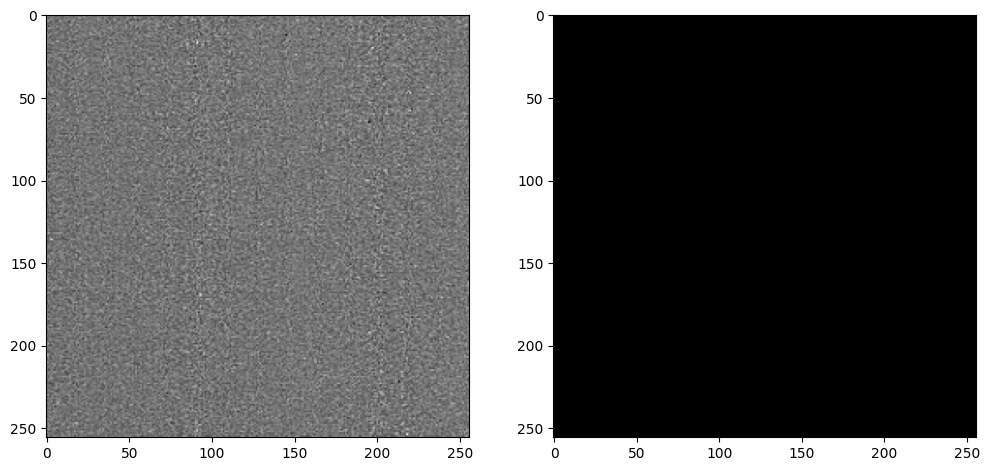

In [875]:
#sanity check: check to make sure images and masks align
import random
image_number = random.randint(0, len(X_train) - 1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train[image_number, :, :, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap = 'gray')
plt.show()

In [876]:
#augmentation for images and masks
seed = 24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.3,
                         height_shift_range=0.3,
                         shear_range=0.5,
                         zoom_range=0.3,
                         horizontal_flip = True,
                         vertical_flip=True,
                         fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                          width_shift_range=0.3,
                          height_shift_range=0.3,
                          shear_range=0.5, 
                          zoom_range=0.3,
                          horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode='reflect',
                          preprocessing_function = lambda x: np.where(x>0,1,0).astype(x.dtype))

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed = seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed = seed)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment = True, seed = seed)
mask_generator = mask_data_generator.flow(y_train, seed = seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed = seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

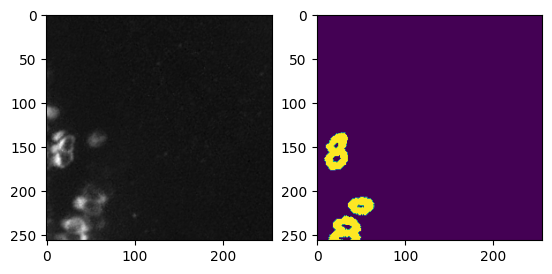

In [884]:
#ensure that that masks align with the image after augmentation
x = image_generator.next()
y = mask_generator.next()

for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap = 'gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [885]:
#load model
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context
model = sm.Unet(BACKBONE, encoder_weights = 'imagenet')
model.compile('Adam', loss = sm.losses.bce_jaccard_loss, metrics = [sm.metrics.iou_score])
print(model.summary())

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_136 (ZeroPa  (None, None, None, 3)        0         ['bn_data[0][0]']             
 dding2D)                                                                                         
                                                                                            

In [887]:
#train model
history = model.fit(my_generator, validation_data = validation_datagen, steps_per_epoch=63, validation_steps = 22, epochs = 40, batch_size = 32)

Epoch 1/40
63/63 [==============================] - 216s 3s/step - loss: 1.1810 - iou_score: 0.0142 - val_loss: 1.4074 - val_iou_score: 0.0037
Epoch 2/40
63/63 [==============================] - 213s 3s/step - loss: 0.9263 - iou_score: 0.1057 - val_loss: 4.2413 - val_iou_score: 2.9886e-06
Epoch 3/40
63/63 [==============================] - 213s 3s/step - loss: 0.7572 - iou_score: 0.2640 - val_loss: 37.8087 - val_iou_score: 0.1364
Epoch 4/40
63/63 [==============================] - 213s 3s/step - loss: 0.6960 - iou_score: 0.3231 - val_loss: 1.0241 - val_iou_score: 0.0028
Epoch 5/40
63/63 [==============================] - 213s 3s/step - loss: 0.6633 - iou_score: 0.3559 - val_loss: 1.0249 - val_iou_score: 0.0048
Epoch 6/40
63/63 [==============================] - 213s 3s/step - loss: 0.6769 - iou_score: 0.3440 - val_loss: 1.0270 - val_iou_score: 0.0016
Epoch 7/40
63/63 [==============================] - 214s 3s/step - loss: 0.6944 - iou_score: 0.3266 - val_loss: 1.0416 - val_iou_score: 2

1/1 [==============================] - 0s 68ms/step


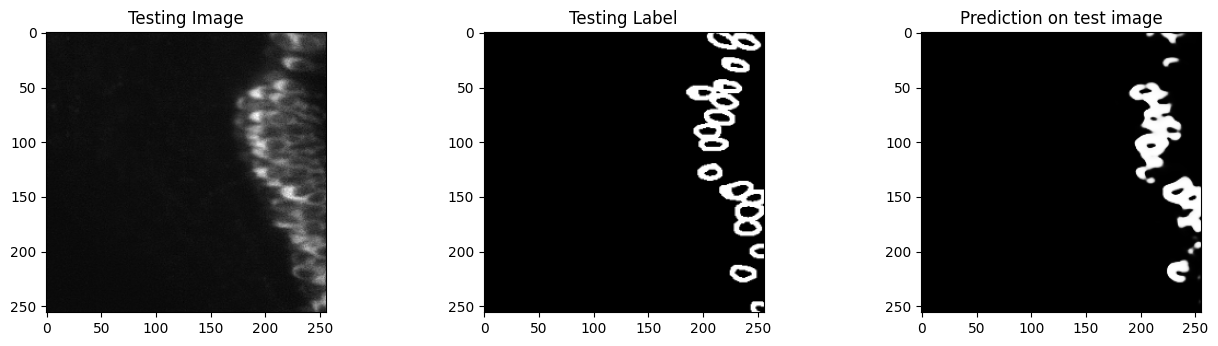

In [939]:
#check to see what predictions are looking like
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
ground_truth = y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction [0,:,:,0]


plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap = 'gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


In [317]:
#save model (change name to whatever you want to save the model as)
model.save('cell_body_segmentation_final.h5')

/Users/group_user/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
